In [1]:
import numpy as np 
import pandas as pd
import datetime as dt
import quandl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# References: 
# https://www.wilmott.com/wp-content/uploads/2016/07/111116_bossu.pdf
# http://www.investment-and-finance.net/derivatives/tutorials/variance-swap-marking-to-market.html
# http://utminers.utep.edu/xzeng/homepage/Presentations_files/MSaE345_Xianyi_Zeng.pdf
# https://github.com/yhilpisch/eurexas/blob/master/variance/01_Variance_Swaps.ipynb

In [3]:
quandl.ApiConfig.api_key = "2iPu61nT4WXex2sh1zsS"

In [4]:
def MtM(row, **kwargs):
    sigma2, t = row["sigma^2"], row["t"]
    units,r,T,strike = kwargs["var_units"], kwargs["r"],kwargs["T"],kwargs["X"]
    # For illustrative purposes, I have used  the strike price for time remaining calculation.
    # In practice should use the market quoted prices for var swap with strike price X and time remaining T-t.
    return units * np.exp(-r * (T-t)) * ((t*sigma2 + (T-t)*strike**2)/T - strike**2)

def variance_payout(stock, vega_notional, vol_strike, r=0.005, start="2015-11-05", end="2017-11-05"):
    start = dt.datetime.strptime(start, "%Y-%M-%d")
    end = dt.datetime.strptime(end, "%Y-%M-%d")
    var_units = vega_notional/(2. * vol_strike)
    var_strike = vol_strike**2
    T = None
    
    try:
        data = quandl.get("WIKI/"+stock,start_date=start, end_date=end)
    except Exception as e:
        print("Failed to get: {}".format(e))
    
    # Calculate log returns.
    data["log_returns"] = np.log(data["Adj. Close"]/data["Adj. Close"].shift(1))
    
    # Shift by 1 as 1 data point is NaN for log returns.
    data = data[1:]
    
    # Number of calculated returns
    T = len(data)
    
    # We are assuming no market distruptive days, thus cumsum is counting all days as valid.
    # RMS but assuming mean is zero.
    data["sigma^2"] = 10000 * 252 * np.cumsum(data['log_returns']**2)/np.arange(T)

    # Shift by one so t starts at 1, as opposed to 0
    data["t"] = np.arange(1,T+1)
    
    # Compute Mark to Market
    data["MtM"] = data.apply(MtM, var_units=var_units, r=r, T=T, X=vol_strike, axis=1)
    
    data[['Adj. Close', 'sigma^2', 'MtM']].plot(subplots=True, figsize=(10, 8), color='blue', grid=True)
    
    return data

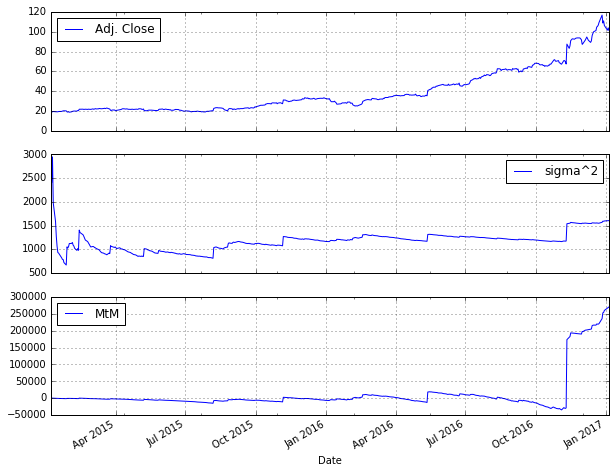

In [5]:
# Specify vega notional amount.
# variance_payout also takes in a r value for the risk free rate (default=0.005). 
vega_notional = 50000
df = variance_payout("NVDA", vega_notional, 35)